# Multiple Myeloma vs Acute Lymphoid Leukemia Classification

##Mount Google Drive that contains training and test data sets.

In [1]:
# Seed value for random number generators to obtain reproducible results
RANDOM_SEED = 63

# Import packages into the namespace for this program
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
import datetime
import csv
import matplotlib.pyplot as plt
import random as rn

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.utils import to_categorical, plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU

import cv2
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from google.colab import drive
drive.mount('/content/gdrive')


Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Define functions to load training and test images

In [0]:
def load_train_images(folder):
    images = []
    labels = []
    widths = []
    heights = []

    i = 0
    for filename in os.listdir(folder):
      if i % 5 == 0:
        print("Loading image " + str(i))

      img = cv2.imread(os.path.join(folder, filename))
      if img is not None:
        images.append(img)
        heights.append(img.shape[0])
        widths.append(img.shape[1])
        # extract the class label from the image path and update the
        # labels list
        label = filename.split("_")[0]
        label = 1 if label == "MM" else 0
        labels.append(label)
        # Augment data by flipping each image on both axes
        both_axes_img = cv2.flip(img, -1)
        images.append(both_axes_img)
        labels.append(label)
      i+= 1

    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)

    print("\n\nAverage Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print("\nAverage Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))

    return images, np.array(labels), avg_width, avg_height


def resize_train_images(images, width_resized, height_resized):
    images_resized = []

    # Resize
    i = 0
    for img in images:
      image_resized = cv2.resize(img, (width_resized, height_resized), interpolation=cv2.INTER_CUBIC)
      images_resized.append(image_resized)

      i+= 1

    return np.array(images_resized)


def resize_test_images(images, width_resized, height_resized):
    images_resized = []
    images_resized_flat = []
    # Resize
    i = 0
    for img in images:
      image_resized = cv2.resize(img, (width_resized, height_resized), interpolation=cv2.INTER_CUBIC)
      images_resized.append(image_resized)

    return np.array(images_resized)



##Load training images and labels

In [3]:
path = "/content/gdrive/My Drive/MM_ALL/"
images, labels, avg_width, avg_height = load_train_images(path)

images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.2, random_state=RANDOM_SEED)

# Reclaim memory for raw images and labels
del images, labels

# Convert labels to one-hot vector
y_train_one_hot = to_categorical(labels_train)
y_test_one_hot = to_categorical(labels_test)

# Determine class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(labels_train),
                                                  labels_train)
class_weight_dict = dict(enumerate(class_weights))
print("\nClass weights: " + str(class_weight_dict))

Loading image 0
Loading image 5
Loading image 10
Loading image 15
Loading image 20
Loading image 25
Loading image 30
Loading image 35
Loading image 40
Loading image 45
Loading image 50
Loading image 55
Loading image 60
Loading image 65
Loading image 70
Loading image 75
Loading image 80
Loading image 85
Loading image 90
Loading image 95
Loading image 100
Loading image 105
Loading image 110
Loading image 115
Loading image 120
Loading image 125


Average Height: 1920.0
Max Height: 1920
Min Height: 1920

Average Width: 2560.0
Max Width: 2560
Min Width: 2560

Class weights: {0: 2.3636363636363638, 1: 0.6341463414634146}


#Convolutional Neutal Networks Based on VGG


Instantiate lists of descriptive and performance statitics of the models

In [0]:
model_type_list = []
image_resize_percentage_list = []
activation_type_list = []
processing_time_list = []
train_performance_list = []
test_performance_list = []
image_class_strength = {}

##Activation: Leaky ReLU, Image size: 20% of average original image

###Train the model

In [5]:
# Resize training images to 20% original average width and height
width_resized = round(0.2 * avg_width)
height_resized = round(0.2 * avg_height)
train_images_20 = resize_train_images(images_train, width_resized, height_resized)
print("Shape of training set with resized images shape: " + str(train_images_20.shape))

Shape of training set with resized images shape: (208, 384, 512, 3)


Define the model

In [0]:
# Define model
tf.set_random_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED']=str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

model_type_list.append("VGG")
image_resize_percentage_list.append("20%")
activation_type_list.append("Leaky ReLU")

height = train_images_20.shape[1]
width = train_images_20.shape[2]
depth = train_images_20.shape[3]

objective = 'binary_crossentropy'

classes = 2

def vgg():
  model = Sequential()
  inputShape = (height, width, depth)
  
  model.add(Conv2D(16, kernel_size=(3, 3),
                   input_shape=inputShape, padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.25))
  model.add(Conv2D(32, kernel_size=(3, 3),
                   input_shape=inputShape, padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3),
                   input_shape=inputShape, padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.25))
  model.add(Conv2D(128, kernel_size=(3, 3),
                   padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.25))
  model.add(Conv2D(256, kernel_size=(3, 3),
                   padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.25))

  model.add(Conv2D(512, kernel_size=(3, 3),
                   padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))

  model.compile(loss=objective, optimizer=RMSprop(lr=1e-3), metrics=['accuracy'])
  return model

Training

In [7]:
# Network parameters
batch_size = 20

# Suumarize model and create document of it
model = vgg()
model.summary()
plot_model(model, to_file='/vgg_leakyrelu_20.png', show_shapes=True)


from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', patience=8),
             ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_acc', mode='max',
                             save_best_only=True)]


# Record the time needed to train the network
start = datetime.datetime.now()

# Train neural network
history = model.fit(train_images_20, # Features
                      y_train_one_hot, # Target vector
                      epochs=40, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      shuffle=True,
                      class_weight=class_weight_dict,
                      verbose=1, # Print description after each epoch
                      batch_size=batch_size, # Number of observations per batch
                      validation_split=0.25) # Data for evaluation


print("\nFinal training accuracy:\n" +
      "   " + str(round(model.history.history["acc"][-1],5)) + "\n")


print("Final log loss (crossentropy loss) = " +
      str(round(model.history.history["loss"][-1],5)))

# Display and save the time needed to train the network
end = datetime.datetime.now()
nn_time = (end - start).total_seconds()
print("Elapsed time to train Neural Network Classification:\n" +
      "   " + str(round(nn_time,2)) + " seconds\n")
processing_time_list.append(round(nn_time,2))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 384, 512, 16)      448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 384, 512, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 384, 512, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 192, 256, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 192, 256, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 192, 256, 32)      4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 192, 256, 32)      0         
__________

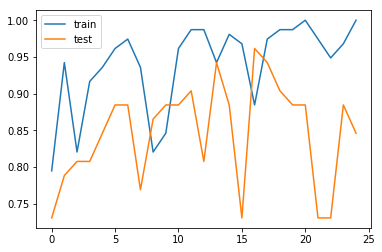

In [8]:
# plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [0]:
# Save best model
saved_model_vgg_leakyrelu_20 = load_model('best_model.h5')

In [10]:
# Create train predictions
y_train_predict = np.argmax(saved_model_vgg_leakyrelu_20.predict(train_images_20), axis=1)
print("Shape of resized train images: " + str(train_images_20.shape))
print("Predicted labels for training set:")
print(str(y_train_predict))
print("\nActual labels for training set:")
print(str(labels_train))

score = accuracy_score(labels_train, y_train_predict, normalize=True)
print("\nTraining set accuracy score = " + str(score))
train_performance_list.append(round(score,3))

Shape of resized train images: (208, 384, 512, 3)
Predicted labels for training set:
[1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1
 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1]

Actual labels for training set:
[1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0
 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1
 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1]

Training set accuracy score = 0.975

###Test the model

Resize test images to same size as the resized training images used for this model

In [11]:
test_images_20 = resize_test_images(images_test, width_resized, height_resized)
print("Shape of resized test images: " + str(test_images_20.shape))

Shape of resized test images: (52, 384, 512, 3)


Create predictions to test data and wite those predictions to csv file

In [12]:
# Create test predictions
y_test_predict = np.argmax(saved_model_vgg_leakyrelu_20.predict(test_images_20), axis=1)
print("Predicted labels for test set:")
print(str(y_test_predict))
print("\nActual labels for test set:")
print(str(labels_test))

score = accuracy_score(labels_test, y_test_predict, normalize=True)
print("\nTest set accuracy score = " + str(score))
test_performance_list.append(round(score,3))


## Open new csv file on Google drive
nn_out = open("/content/gdrive/My Drive/vgg_leakyrelu_20.csv", "wt")
csv_writer = csv.writer(nn_out, delimiter=',', quotechar='"')
## Write headers
csv_writer.writerow(['id','label'])
#
## Write each prediction to separate row
## Each row consists of Image ID and label prediction, comma separated
for i in range(y_test_predict.shape[0]):
  csv_writer.writerow([str(i+1), str(y_test_predict[i])])
  # Find images most strongly classified, those for which
  # abs(label - y_test_predict) are smallest
  image_class_strength[i] = abs(y_test_predict[i] - labels_test[i])
nn_out.close()

# Reclaim memory
try:
  del saved_model_vgg_leakyrelu_20, train_images_20, test_images_20
except NameError:
  pass

Predicted labels for test set:
[1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1]

Actual labels for test set:
[1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1]

Test set accuracy score = 0.9230769230769231


##Activation: Leaky ReLU, Image size: 30% of average original image

###Train the model

In [13]:
# Resize training images to 30% original average width and height
width_resized = round(0.3 * avg_width)
height_resized = round(0.3 * avg_height)
train_images_30 = resize_train_images(images_train, width_resized, height_resized)
print("Shape of training set with resized images shape: " + str(train_images_30.shape))

Shape of training set with resized images shape: (208, 576, 768, 3)


Define the model

In [0]:
# Define model
model_type_list.append("VGG")
image_resize_percentage_list.append("30%")
activation_type_list.append("Leaky ReLU")

height = train_images_30.shape[1]
width = train_images_30.shape[2]
depth = train_images_30.shape[3]

objective = 'binary_crossentropy'

classes = 2

def vgg():
  model = Sequential()
  inputShape = (height, width, depth)
  
  model.add(Conv2D(16, kernel_size=(3, 3),
                   input_shape=inputShape, padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.25))
  model.add(Conv2D(32, kernel_size=(3, 3),
                   input_shape=inputShape, padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3),
                   input_shape=inputShape, padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.25))
  model.add(Conv2D(128, kernel_size=(3, 3),
                   padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.25))
  model.add(Conv2D(256, kernel_size=(3, 3),
                   padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.25))

  model.add(Conv2D(512, kernel_size=(3, 3),
                   padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))

  model.compile(loss=objective, optimizer=RMSprop(lr=1e-3), metrics=['accuracy'])
  return model

Training

In [15]:
# Network parameters
batch_size = 20

# Suumarize model and create document of it
model = vgg()
model.summary()
plot_model(model, to_file='/vgg_leakyrelu_30.png', show_shapes=True)


from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', patience=8),
             ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_acc', mode='max',
                             save_best_only=True)]


# Record the time needed to train the network
start = datetime.datetime.now()

# Train neural network
history = model.fit(train_images_30, # Features
                      y_train_one_hot, # Target vector
                      epochs=40, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      shuffle=True,
                      class_weight=class_weight_dict,
                      verbose=1, # Print description after each epoch
                      batch_size=batch_size, # Number of observations per batch
                      validation_split=0.25) # Data for evaluation


print("\nFinal training accuracy:\n" +
      "   " + str(round(model.history.history["acc"][-1],5)) + "\n")


print("Final log loss (crossentropy loss) = " +
      str(round(model.history.history["loss"][-1],5)))

# Display and save the time needed to train the network
end = datetime.datetime.now()
nn_time = (end - start).total_seconds()
print("Elapsed time to train Neural Network Classification:\n" +
      "   " + str(round(nn_time,2)) + " seconds\n")
processing_time_list.append(round(nn_time,2))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 576, 768, 16)      448       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 576, 768, 16)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 576, 768, 16)      64        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 288, 384, 16)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 288, 384, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 288, 384, 32)      4640      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 288, 384, 32)      0         
__________

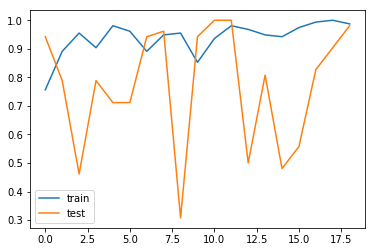

In [16]:
# plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [0]:
# Save best model
saved_model_vgg_leakyrelu_30 = load_model('best_model.h5')

In [18]:
# Create train predictions
y_train_predict = np.argmax(saved_model_vgg_leakyrelu_30.predict(train_images_30), axis=1)
print("Shape of resized train images: " + str(train_images_30.shape))
print("Predicted labels for training set:")
print(str(y_train_predict))
print("\nActual labels for training set:")
print(str(labels_train))

score = accuracy_score(labels_train, y_train_predict, normalize=True)
print("\nTraining set accuracy score = " + str(score))
train_performance_list.append(round(score,3))

Shape of resized train images: (208, 576, 768, 3)
Predicted labels for training set:
[1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0
 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1
 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1]

Actual labels for training set:
[1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0
 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1
 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1]

Training set accuracy score = 1.0


###Test the model

Resize test images to same size as the resized training images used for this model

In [19]:
test_images_30 = resize_test_images(images_test, width_resized, height_resized)
print("Shape of resized test images: " + str(test_images_30.shape))

Shape of resized test images: (52, 576, 768, 3)


Create predictions to test data and wite those predictions to csv file

In [20]:
# Create test predictions
y_test_predict = np.argmax(saved_model_vgg_leakyrelu_30.predict(test_images_30), axis=1)
print("Predicted labels for test set:")
print(str(y_test_predict))
print("\nActual labels for test set:")
print(str(labels_test))

score = accuracy_score(labels_test, y_test_predict, normalize=True)
print("\nTest set accuracy score = " + str(score))
test_performance_list.append(round(score,3))


## Open new csv file on Google drive
nn_out = open("/content/gdrive/My Drive/vgg_leakyrelu_30.csv", "wt")
csv_writer = csv.writer(nn_out, delimiter=',', quotechar='"')
## Write headers
csv_writer.writerow(['id','label'])
#
## Write each prediction to separate row
## Each row consists of Image ID and label prediction, comma separated
for i in range(y_test_predict.shape[0]):
  csv_writer.writerow([str(i+1), str(y_test_predict[i])])
  # Find images most strongly classified, those for which
  # abs(label  - y_test_predict) are smallest
  curr_strength = image_class_strength[i]
  image_class_strength[i] = curr_strength + abs(y_test_predict[i] - labels_test[i])
  
nn_out.close()

# Reclaim memory
try:
  del saved_model_vgg_leakyrelu_30, train_images_30, test_images_30
except NameError:
  pass

Predicted labels for test set:
[1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1]

Actual labels for test set:
[1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1]

Test set accuracy score = 0.9807692307692307


##Activation: Leaky ReLU, Image size: 40% of average original image

###Train the model

In [21]:
# Resize training images to 40% original average width and height
width_resized = round(0.4 * avg_width)
height_resized = round(0.4 * avg_height)
train_images_40 = resize_train_images(images_train, width_resized, height_resized)
print("Shape of training set with resized images shape: " + str(train_images_40.shape))

Shape of training set with resized images shape: (208, 768, 1024, 3)


Define the model

In [0]:
# Define model
model_type_list.append("VGG")
image_resize_percentage_list.append("40%")
activation_type_list.append("Leaky ReLU")

height = train_images_40.shape[1]
width = train_images_40.shape[2]
depth = train_images_40.shape[3]

objective = 'binary_crossentropy'

classes = 2

def vgg():
  model = Sequential()
  inputShape = (height, width, depth)
  
  model.add(Conv2D(16, kernel_size=(3, 3),
                   input_shape=inputShape, padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.25))
  model.add(Conv2D(32, kernel_size=(3, 3),
                   input_shape=inputShape, padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3),
                   input_shape=inputShape, padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.25))
  model.add(Conv2D(128, kernel_size=(3, 3),
                   padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.25))
  model.add(Conv2D(256, kernel_size=(3, 3),
                   padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.25))

  model.add(Conv2D(512, kernel_size=(3, 3),
                   padding="same"))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))

  model.compile(loss=objective, optimizer=RMSprop(lr=1e-3), metrics=['accuracy'])
  return model

Training

In [23]:
# Network parameters
batch_size = 20

# Suumarize model and create document of it
model = vgg()
model.summary()
plot_model(model, to_file='/vgg_leakyrelu_40.png', show_shapes=True)


from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', patience=8),
             ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_acc', mode='max',
                             save_best_only=True)]


# Record the time needed to train the network
start = datetime.datetime.now()

# Train neural network
history = model.fit(train_images_40, # Features
                      y_train_one_hot, # Target vector
                      epochs=40, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      shuffle=True,
                      class_weight=class_weight_dict,
                      verbose=1, # Print description after each epoch
                      batch_size=batch_size, # Number of observations per batch
                      validation_split=0.25) # Data for evaluation


print("\nFinal training accuracy:\n" +
      "   " + str(round(model.history.history["acc"][-1],5)) + "\n")


print("Final log loss (crossentropy loss) = " +
      str(round(model.history.history["loss"][-1],5)))

# Display and save the time needed to train the network
end = datetime.datetime.now()
nn_time = (end - start).total_seconds()
print("Elapsed time to train Neural Network Classification:\n" +
      "   " + str(round(nn_time,2)) + " seconds\n")
processing_time_list.append(round(nn_time,2))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 768, 1024, 16)     448       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 768, 1024, 16)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 768, 1024, 16)     64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 384, 512, 16)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 384, 512, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 384, 512, 32)      4640      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 384, 512, 32)      0         
__________

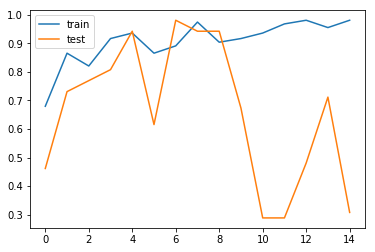

In [24]:
# plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [0]:
# Save best model
saved_model_vgg_leakyrelu_40 = load_model('best_model.h5')

In [26]:
# Create train predictions
y_train_predict = np.argmax(saved_model_vgg_leakyrelu_40.predict(train_images_40), axis=1)
print("Shape of resized train images: " + str(train_images_40.shape))
print("Predicted labels for training set:")
print(str(y_train_predict))
print("\nActual labels for training set:")
print(str(labels_train))

score = accuracy_score(labels_train, y_train_predict, normalize=True)
print("\nTraining set accuracy score = " + str(score))
train_performance_list.append(round(score,3))

Shape of resized train images: (208, 768, 1024, 3)
Predicted labels for training set:
[1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0
 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1
 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1]

Actual labels for training set:
[1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0
 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1
 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1]

Training set accuracy score = 0.99

###Test the model

Resize test images to same size as the resized training images used for this model

In [27]:
test_images_40 = resize_test_images(images_test, width_resized, height_resized)
print("Shape of resized test images: " + str(test_images_40.shape))

Shape of resized test images: (52, 768, 1024, 3)


Create predictions to test data and wite those predictions to csv file for upload to Kaggle for scoring

In [28]:
# Create test predictions
y_test_predict = np.argmax(saved_model_vgg_leakyrelu_40.predict(test_images_40), axis=1)
print("Predicted labels for test set:")
print(str(y_test_predict))
print("\nActual labels for test set:")
print(str(labels_test))

score = accuracy_score(labels_test, y_test_predict, normalize=True)
print("\nTest set accuracy score = " + str(score))
test_performance_list.append(round(score,3))


## Open new csv file on Google drive
nn_out = open("/content/gdrive/My Drive/vgg_leakyrelu_40.csv", "wt")
csv_writer = csv.writer(nn_out, delimiter=',', quotechar='"')
## Write headers
csv_writer.writerow(['id','label'])
#
## Write each prediction to separate row
## Each row consists of Image ID and label prediction, comma separated
for i in range(y_test_predict.shape[0]):
  csv_writer.writerow([str(i+1), str(y_test_predict[i])])
  # Find images most strongly classified, those for which
  # abs(label  - y_test_predict) are smallest
  curr_strength = image_class_strength[i]
  image_class_strength[i] = curr_strength + abs(y_test_predict[i] - labels_test[i])
nn_out.close()

# Reclaim memory for model
try:
  del saved_model_vgg_leakyrelu_40
except NameError:
  pass

Predicted labels for test set:
[1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1]

Actual labels for test set:
[1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1]

Test set accuracy score = 1.0


#Conclusions

Display summary table of performance for all tested models

In [29]:
performances = pd.DataFrame(
    np.column_stack([model_type_list, image_resize_percentage_list,
                     activation_type_list, processing_time_list,
                     train_performance_list,
                     test_performance_list]), 
    columns=['Model Type', 'Image Resize %', 'Activation Type',
           'Processing Time', 'Train Accuracy', 'Test Accuracy'])
display(performances)


,Model Type,Image Resize %,Activation Type,Processing Time,Train Accuracy,Test Accuracy
0,VGG,20%,Leaky ReLU,48.8,0.976,0.923
1,VGG,30%,Leaky ReLU,77.26,1.0,0.981
2,VGG,40%,Leaky ReLU,111.63,0.99,1.0


Display examples of best and worst performing images. In this case, performance is judged by the cumulative amount over all tested models that the classification score of a test image is from 0.5, either above or below. It is a measure of the confidence in the classification of that image made by the model.

2 Worst performing images:


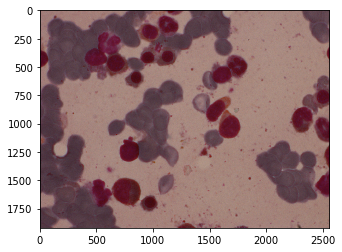

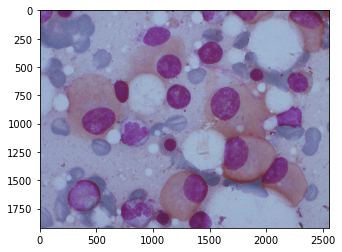



2 Best performing images:


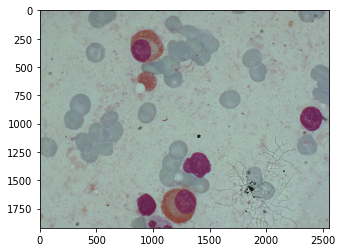

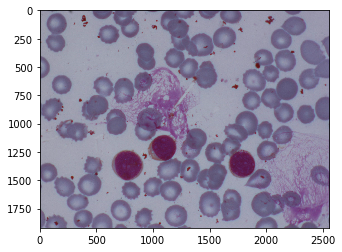

In [30]:
strengths_sorted_asc = sorted(image_class_strength, key=image_class_strength.__getitem__)
strengths_sorted_desc = sorted(image_class_strength, key=image_class_strength.__getitem__, reverse=True)

print("2 Worst performing images:")
i = 0
for key in strengths_sorted_desc:
  plt.imshow(images_test[key])
  plt.show()
  i+= 1
  if i > 1:
    break

print("\n\n2 Best performing images:")
i = 0
for key in strengths_sorted_asc:
  plt.imshow(images_test[key])
  plt.show()
  plt.show()
  i+= 1
  if i > 1:
    break

Graph the test accuracy scores and total time elaspsed of the various models

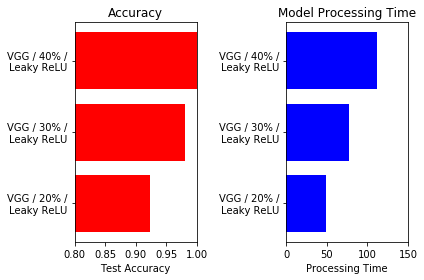

In [31]:
# Test Accuracy of model
y_pos = np.arange(len(processing_time_list))
plt.subplot(1, 2, 1)
plt.barh(y_pos, [test_performance_list[i] for i in range(
    len(test_performance_list))], align='center', color='red')
plt.yticks(y_pos, ["VGG / 20% /\nLeaky ReLU",
                   "VGG / 30% /\nLeaky ReLU",
                   "VGG / 40% /\nLeaky ReLU"])
plt.xlabel('Test Accuracy')
plt.title('Accuracy')
plt.xlim([0.8,1])
plt.tight_layout()


# Elapsed time of all models
plt.subplot(1, 2, 2)
plt.barh(y_pos, [processing_time_list[i] for i in range(
    len(processing_time_list))], align='center', color='blue')
plt.yticks(y_pos, ["VGG / 20% /\nLeaky ReLU",
                   "VGG / 30% /\nLeaky ReLU",
                   "VGG / 40% /\nLeaky ReLU"])
plt.xlabel('Processing Time')
plt.title('Model Processing Time')
plt.xlim([0,150])
plt.tight_layout()
plt.show()

* The best performing configuration of the VGG model with Leaky ReLU activations and either 30% or 40% scaling of the original images achieves at least 95% accuracy on both the training and test sets. (Random shuffling of the training data by the model at each epoch may lead to results that are not entirely consistent from run to run.) The model with 40% scaling does take  more processing time but generally achieves better performance.